In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

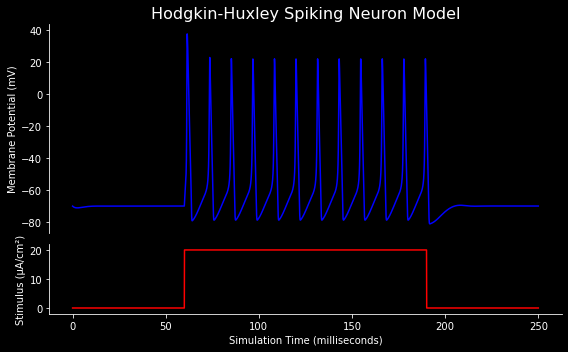

In [2]:
class HHModel:
    """The HHModel tracks conductances of 3 channels to calculate Vm"""

    class Gate:
        """The Gate object manages a channel's kinetics and open state"""
        alpha, beta, state = 0, 0, 0

        def update(self, deltaTms):
            alphaState = self.alpha * (1-self.state)
            betaState = self.beta * self.state
            self.state += deltaTms * (alphaState - betaState)

        def setInfiniteState(self):
            self.state = self.alpha / (self.alpha + self.beta)

    ENa, EK, EKleak = 115, -12, 10.6
    gNa, gK, gKleak = 120, 36, 0.3
    m, n, h = Gate(), Gate(), Gate()
    Cm = 1

    def __init__(self, startingVoltage=0):
        self.Vm = startingVoltage
        self.UpdateGateTimeConstants(startingVoltage)
        self.m.setInfiniteState()
        self.n.setInfiniteState()
        self.n.setInfiniteState()

    def UpdateGateTimeConstants(self, Vm):
        """Update time constants of all gates based on the given Vm"""
        self.n.alpha = .01 * ((10-Vm) / (np.exp((10-Vm)/10)-1))
        self.n.beta = .125*np.exp(-Vm/80)
        self.m.alpha = .1*((25-Vm) / (np.exp((25-Vm)/10)-1))
        self.m.beta = 4*np.exp(-Vm/18)
        self.h.alpha = .07*np.exp(-Vm/20)
        self.h.beta = 1/(np.exp((30-Vm)/10)+1)

    def UpdateCellVoltage(self, stimulusCurrent, deltaTms):
        """calculate channel currents using the latest gate time constants"""
        INa = np.power(self.m.state, 3) * self.gNa * \
            self.h.state*(self.Vm-self.ENa)
        IK = np.power(self.n.state, 4) * self.gK * (self.Vm-self.EK)
        IKleak = self.gKleak * (self.Vm-self.EKleak)
        Isum = stimulusCurrent - INa - IK - IKleak
        self.Vm += deltaTms * Isum / self.Cm

    def UpdateGateStates(self, deltaTms):
        """calculate new channel open states using latest Vm"""
        self.n.update(deltaTms)
        self.m.update(deltaTms)
        self.h.update(deltaTms)

    def Iterate(self, stimulusCurrent=0, deltaTms=0.05):
        self.UpdateGateTimeConstants(self.Vm)
        self.UpdateCellVoltage(stimulusCurrent, deltaTms)
        self.UpdateGateStates(deltaTms)


if __name__ == "__main__":
    hh = HHModel()
    pointCount = 5000
    voltages = np.empty(pointCount)
    times = np.arange(pointCount) * 0.05
    stim = np.zeros(pointCount)
    stim[1200:3800] = 20  # create a square pulse

    for i in range(len(times)):
        hh.Iterate(stimulusCurrent=stim[i], deltaTms=0.05)
        voltages[i] = hh.Vm
        # note: you could also plot hh's n, m, and k (channel open states)

    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                                 gridspec_kw={'height_ratios': [3, 1]})

    ax1.plot(times, voltages - 70, 'b')
    ax1.set_ylabel("Membrane Potential (mV)")
    ax1.set_title("Hodgkin-Huxley Spiking Neuron Model", fontsize=16)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(bottom=False)

    ax2.plot(times, stim, 'r')
    ax2.set_ylabel("Stimulus (µA/cm²)")
    ax2.set_xlabel("Simulation Time (milliseconds)")
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    plt.margins(0, 0.1)
    plt.tight_layout()
    plt.show()